Notebook del modelo de árbol de decisión del dataframe de las peleas ponderadas

- **Tarea del backlog:** https://github.com/UCM-GIDIA-PD1/c2425-R4/issues/31
- **Propósito del código:** Árbol de clasificación para el dataframe de peleas ponderadas (P2).
- **Autor(es):** Carlos Vallejo.  
- **Descripción y uso:** Ejecutar para ver el resultado del modelo de árbol de clasificación en P2.
- **Estado actual:** Primer modelo, falta mejorarlo.

In [ ]:
#NO BORRAR ESTA CELDA!!!!!!!!!!!!!!!!

#Marca con un * al final las que ya estén solucionadas

#Solucionar:
#No hay estudio de transformaciones *
#Se evaluan los modelos con accuracy en vez de f1-score (se explica el porque en la memoria) *
#Explica cada modelo un poco: que hace, porque lo usas *
#No hay estudio de selección de variables. Si es necesario hacer una selección indicar que algoritmo de selección de variables usar. *

In [1]:
import os
import pandas as pd
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, TimeSeriesSplit
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score,log_loss, f1_score, roc_auc_score, precision_score, recall_score, make_scorer
from sklearn import tree  
from sklearn.tree import plot_tree

import seaborn as sns
import matplotlib.pyplot as plt

In [9]:
#los parquet ya están divididos entre train, test y validación
ruta_train =  os.path.join("..","..","..", "data", "P2","train.parquet")
train = pd.read_parquet(ruta_train)
train.head()

,DATE,Peleador_A,Peleador_B,WINNER,KD_A,KD_B,SIG_STR_A,SIG_STR_B,TD_PORC_A,TD_PORC_B,...,Puntos_A,Puntos_B,Peleas_A,Peleas_B,KD_DIFF,SIG_STR_DIFF,TD_DIFF,SUB_ATT_DIFF,REV_DIFF,CTRL_DIFF
0,2011-01-22,Melvin Guillard,Evan Dunham,False,0.24,0.00,0.4772,0.3612,0.0000,0.4200,...,10.302760,0.000000,12,5,0.24,0.1160,-0.475248,-3.16,0.80,-185.76
1,2011-02-26,George Sotiropoulos,Dennis Siver,True,0.24,0.36,0.2548,0.2912,0.4812,0.1600,...,18.618225,14.838304,7,10,-0.12,-0.0364,0.081182,1.56,0.00,228.72
2,2011-03-19,Ricardo Almeida,Mike Pyle,True,0.00,0.24,0.5056,0.5132,0.4500,0.1368,...,10.699383,1.382640,10,5,-0.24,-0.0076,0.255163,-1.08,-0.24,238.92
3,2011-03-19,Mirko Filipovic,Brendan Schaub,True,0.24,1.00,0.3820,0.5688,0.0000,0.0000,...,0.741553,8.765110,8,4,-0.76,-0.1868,0.000000,0.88,0.00,143.08
4,2011-03-19,Dan Miller,Nate Marquardt,True,0.00,0.00,0.3032,0.3912,0.4600,0.2700,...,10.585655,4.242632,8,13,0.00,-0.0880,0.093856,-0.92,-0.40,188.52


In [10]:
ruta_val = os.path.join("..","..","..", "data", "P2","validation.parquet")
val = pd.read_parquet(ruta_val)
val.head()

,DATE,Peleador_A,Peleador_B,WINNER,KD_A,KD_B,SIG_STR_A,SIG_STR_B,TD_PORC_A,TD_PORC_B,...,Puntos_A,Puntos_B,Peleas_A,Peleas_B,KD_DIFF,SIG_STR_DIFF,TD_DIFF,SUB_ATT_DIFF,REV_DIFF,CTRL_DIFF
0,2022-02-12,King Green,Nasrat Haqparast,False,0.36,0.00,0.5736,0.4404,0.264,0.0000,...,12.485966,59.621876,17,8,0.36,0.1332,0.298507,0.00,0.40,31.92
1,2022-02-12,Derrick Lewis,Tai Tuivasa,True,0.76,1.00,0.4032,0.6548,0.000,0.0000,...,208.290685,134.897868,23,10,-0.24,-0.2516,0.000000,0.00,0.00,-46.00
2,2022-02-12,Israel Adesanya,Robert Whittaker,False,0.40,0.64,0.5660,0.4672,0.000,0.2652,...,456.078219,210.208405,11,17,-0.24,0.0988,-0.243478,0.00,0.72,-167.24
3,2022-02-12,Alexander Hernandez,Renato Moicano,True,0.76,0.00,0.4828,0.5228,0.000,0.6556,...,10.000000,10.000000,8,11,0.76,-0.0400,-0.528846,-0.76,0.00,-173.80
4,2022-02-12,Jared Cannonier,Derek Brunson,False,0.76,0.00,0.4900,0.5232,0.000,0.5000,...,71.674377,182.418891,12,19,0.76,-0.0332,-0.445887,-0.60,0.00,-460.76


OBJETIVO

El objetivo de hacer un árbol de decisión no es tanto sacar los resultados más óptimos, sino ver las variables que tienen más importancia.

TRANSFORMACIONES

No es necesario hacer transformaciones para hacer un árbol de decisión ya que estos pueden manejar los datos sin estos cambios.

SELECCIÓN DE VARIABLES

Tampoco es necesario hacer una selección de variables ya que los árboles de decisión no se ven afectados por diferencias en las magnitudes de las variables, además de que el propio árbol selecciona las características más relevantes de las variables.

AJUSTE DE HIPERPARÁMETROS

Para ajustar los parámetros hemos utilizado dos estrategias, GridSearchCV y RandomizedSearchCV. Primero probamos a hacer un modelo con Grid Search.

In [47]:
def train_decision_tree_grid(X_train, y_train, X_val, y_val):
    from sklearn.tree import plot_tree
    # Calcular pesos de clase para manejar desbalance de datos
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}
    tscv = TimeSeriesSplit(n_splits=5)


    # Definir modelo base
    dt = DecisionTreeClassifier(random_state=42)

    # Cuadrícula de hiperparámetros
    param_grid = {
        'criterion': ['gini', 'entropy'],  # Función para medir la calidad de la división
        'max_depth': [3,5,10],  # Profundidad máxima del árbol
        'min_samples_split': [2, 5, 10],  # Mínimo de muestras para dividir un nodo
        'min_samples_leaf': [1, 2, 4],  # Mínimo de muestras en una hoja
        'min_weight_fraction_leaf': [0.01, 0.1, 0.15],
        'splitter': ['best'],
        'class_weight': [None, class_weight_dict],  # Ajuste de pesos por clase
        'max_features': [None, 'sqrt', 'log2']
    }
    

    f1_scorer = make_scorer(f1_score, average='macro')

    # Búsqueda de hiperparámetros con validación cruzada
    grid_search = GridSearchCV(
        estimator=dt,
        param_grid=param_grid,
        scoring= f1_scorer,
        cv=tscv,
        n_jobs=-1,
        verbose=2
    )

    # Entrenar el modelo
    grid_search.fit(X_train, y_train)

    # Imprimir mejores parámetros
    print("Mejores parámetros:", grid_search.best_params_)

    # Evaluar el mejor modelo en el conjunto de validación
    y_pred = grid_search.best_estimator_.predict(X_val)
    print("Reporte de clasificación:")
    print(classification_report(y_val, y_pred))

    # Visualización del árbol
    plt.figure(figsize=(15, 8))
    plot_tree(grid_search.best_estimator_, filled=True, feature_names=X_train.columns, class_names=["False", "True"])
    plt.show()

    return grid_search.best_estimator_

Fitting 5 folds for each of 972 candidates, totalling 4860 fits
Mejores parámetros: {'class_weight': {0: np.float64(0.8849104859335039), 1: np.float64(1.149501661129568)}, 'criterion': 'gini', 'max_depth': 3, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.1, 'splitter': 'best'}
Reporte de clasificación:
              precision    recall  f1-score   support

       False       0.58      0.37      0.45       239
        True       0.48      0.69      0.57       205

    accuracy                           0.52       444
   macro avg       0.53      0.53      0.51       444
weighted avg       0.53      0.52      0.50       444



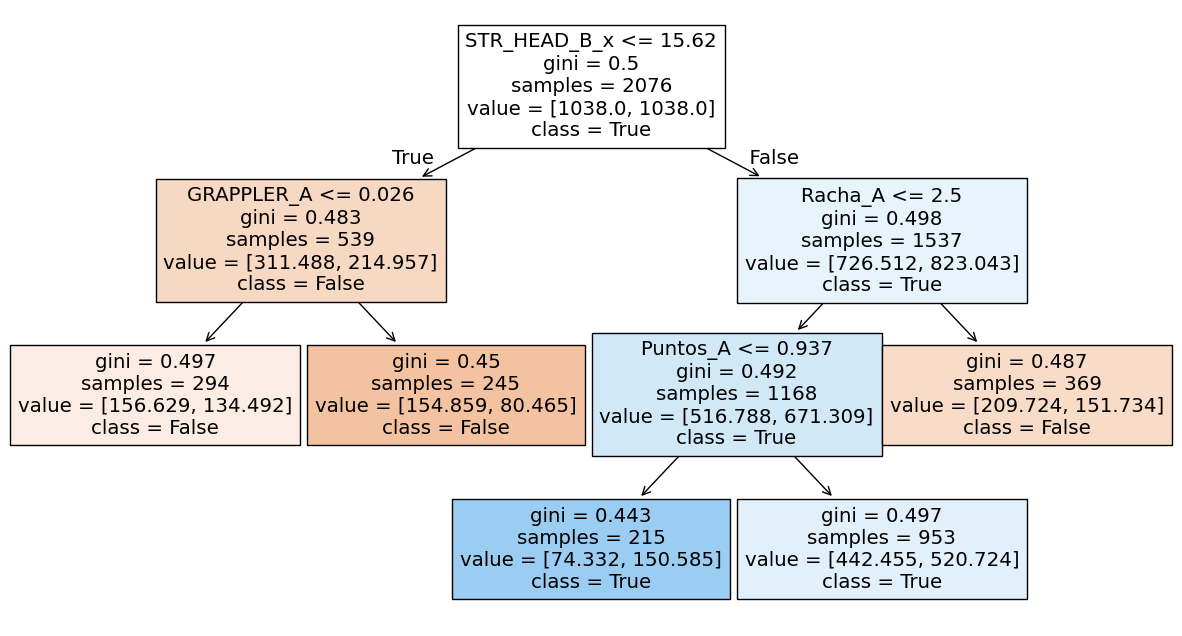

In [48]:
columnasQuitar = ["DATE","Peleador_A","Peleador_B", "WINNER"] #categóricas y variable respuesta

X_train = train.drop(columns=columnasQuitar)
y_train = train['WINNER']
X_val = val.drop(columns=columnasQuitar)
y_val = val['WINNER']


tree = train_decision_tree_grid(X_train, y_train, X_val, y_val)

Variables con importancia en el modelo: STR_HEAD_B_x, Importancia: 0.35544
Variables con importancia en el modelo: GRAPPLER_A, Importancia: 0.11244
Variables con importancia en el modelo: Racha_A, Importancia: 0.35053
Variables con importancia en el modelo: Puntos_A, Importancia: 0.18159


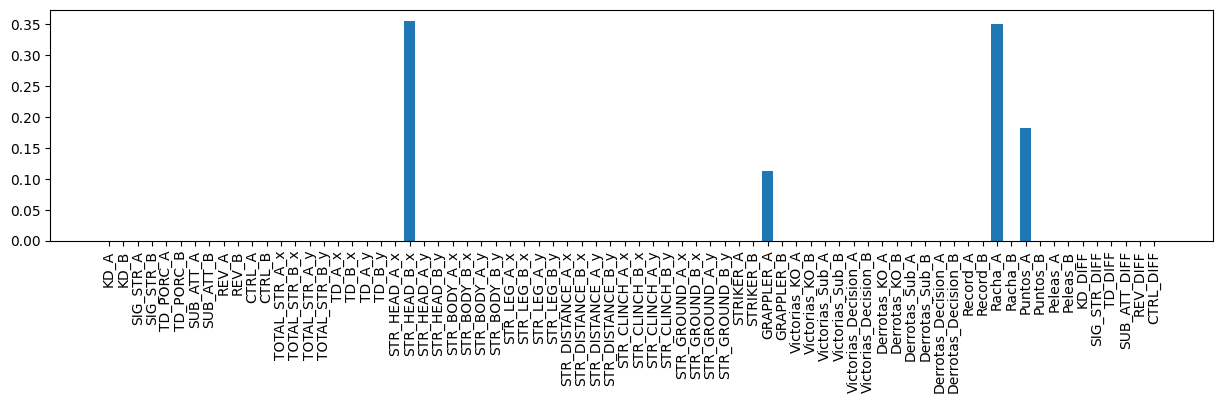

In [26]:
importance = tree.feature_importances_
feature_names=X_train.columns
for i,v in enumerate(importance):
	if v > 0:
	    print('Variables con importancia en el modelo: %s, Importancia: %.5f' % (feature_names[i],v))

plt.figure(figsize=(15, 3))
plt.bar([x for x in range(len(importance))], importance, tick_label = feature_names)
plt.xticks(rotation = 90)
plt.show()

Como vemos el árbol con mejor f1_score tiene max_depth = 3, lo que hace que no haya muchas variables importantes ya que se usan pocas en el modelo.

In [49]:
#Observamos todos los valores de las métricas.
print("-- Métricas del modelo con hiperparámetros ajustados --")
y_val_pred = tree.predict(X_val)
y_val_prob = tree.predict_proba(X_val)[:,1]
print("Accuracy:", accuracy_score(y_val, y_val_pred))
f1_val = f1_score(y_val, y_val_pred)
roc_auc_val = roc_auc_score(y_val, y_val_prob)
precision_val = precision_score(y_val, y_val_pred)
recall_val = recall_score(y_val, y_val_pred)
log_loss_val = log_loss(y_val,y_val_prob)
print(f"F1-Score: {f1_val:.4f}")
print(f"AUC-ROC: {roc_auc_val:.4f}")
print(f"Precisión: {precision_val:.4f}")
print(f"Sensibilidad: {recall_val:.4f}")
print(f"Log-loss: {log_loss_val}")
print(confusion_matrix(y_val, y_val_pred))


-- Métricas del modelo con hiperparámetros ajustados --
Accuracy: 0.5157657657657657
F1-Score: 0.5674
AUC-ROC: 0.5480
Precisión: 0.4829
Sensibilidad: 0.6878
Log-loss: 0.6916916378399818
[[ 88 151]
 [ 64 141]]


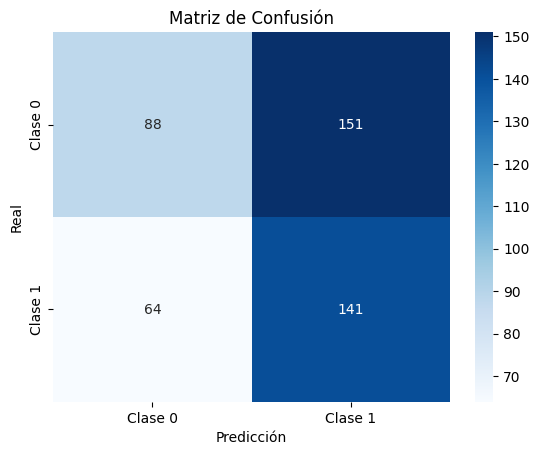

In [25]:
# Calcular la matriz de confusión
cm = confusion_matrix(y_val, y_val_pred)

# Visualizar la matriz de confusión
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Clase 0', 'Clase 1'], yticklabels=['Clase 0', 'Clase 1'])
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión')
plt.show()

Como vemos, con Grid Search el modelo no es bueno ya que ronda el 0.5 en métricas como el f1_score o el accuracy. No obstante, como previamente hemos dicho, este no era el objetivo del modelo. Vamos a probar con Random Search.

In [43]:
def train_decision_tree_random(X_train, y_train, X_val, y_val):
    from sklearn.tree import plot_tree
    # Calcular pesos de clase para manejar desbalance de datos
    class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
    class_weight_dict = {cls: weight for cls, weight in zip(np.unique(y_train), class_weights)}
    tscv = TimeSeriesSplit(n_splits=5)

    # Definir modelo base
    dt2 = DecisionTreeClassifier(random_state=42, class_weight=class_weight_dict)

    # Distribución de hiperparámetros para búsqueda aleatoria
    param_dist = {
    "criterion": ["gini", "entropy"],
    "max_depth": [3],
    "min_samples_split": [int(x) for x in np.arange(2, 20, 2)],
    "min_samples_leaf": [int(x) for x in np.arange(1, 20, 2)],
    'min_weight_fraction_leaf': [0.1, 0.15, 0.2],
    'splitter': ['best'],
    "max_features": ["sqrt", "log2", None],
    'class_weight': [None, class_weight_dict],  # Ajuste de pesos por clase
    }

    #  ['ccp_alpha', 'class_weight', 'max_leaf_nodes', 'min_impurity_decrease',
    #  'min_weight_fraction_leaf', 'monotonic_cst', 'random_state']  otros posibles parámetros

    # Definir la métrica de optimización como el F1-score macro
    f1_scorer = make_scorer(f1_score, average='macro')

    # Búsqueda con validación cruzada
    random_search = RandomizedSearchCV(
        estimator=dt2,
        param_distributions=param_dist,
        scoring=f1_scorer,
        n_iter=50,
        cv=tscv,
        n_jobs=-1,
        verbose=2,
        random_state=42
    )


    # Entrenar el modelo
    random_search.fit(X_train, y_train)

    # Imprimir mejores parámetros
    print("Mejores parámetros:", random_search.best_params_)

    # Evaluar el mejor modelo en el conjunto de validación
    y_pred = random_search.best_estimator_.predict(X_val)
    print("Reporte de clasificación:")
    print(classification_report(y_val, y_pred))

    plt.figure(figsize=(15, 8))
    plot_tree(random_search.best_estimator_, filled=True, feature_names=X_train.columns, class_names=["False", "True"])
    plt.show()

    return random_search.best_estimator_

-- Entrenamiento usando ajuste de hiperparámetros con RandomizedSeachCV --
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Mejores parámetros: {'splitter': 'best', 'min_weight_fraction_leaf': 0.1, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': None, 'max_depth': 3, 'criterion': 'gini', 'class_weight': {np.False_: np.float64(0.8849104859335039), np.True_: np.float64(1.149501661129568)}}
Reporte de clasificación:
              precision    recall  f1-score   support

       False       0.58      0.37      0.45       239
        True       0.48      0.69      0.57       205

    accuracy                           0.52       444
   macro avg       0.53      0.53      0.51       444
weighted avg       0.53      0.52      0.50       444



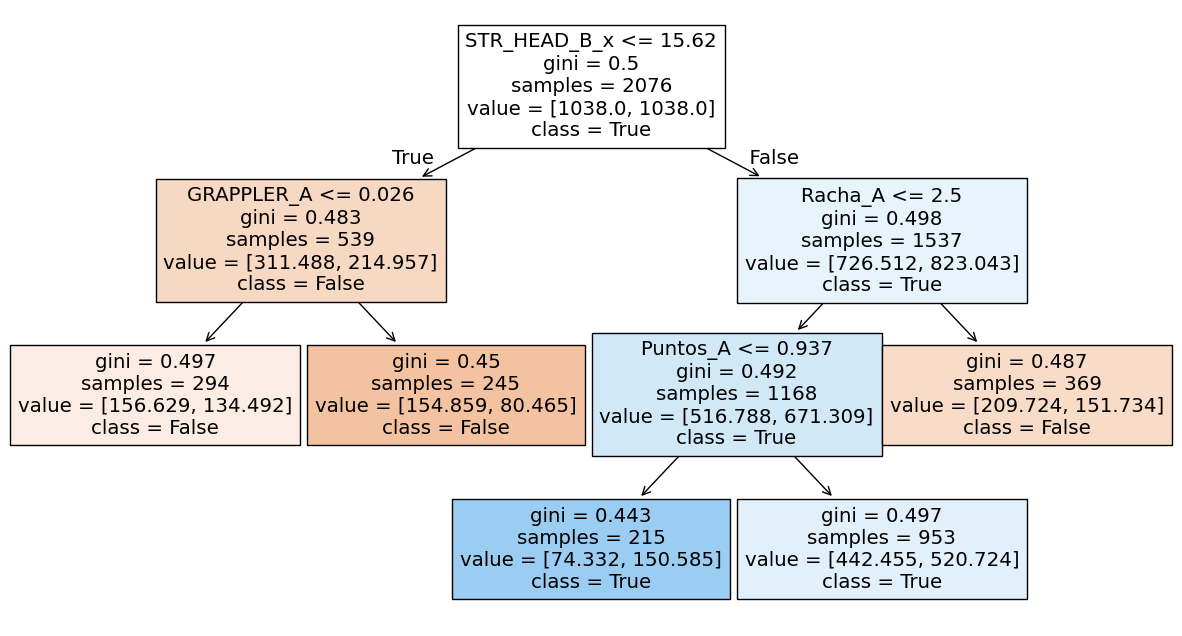

In [44]:
print("-- Entrenamiento usando ajuste de hiperparámetros con RandomizedSeachCV --")
tree2 = train_decision_tree_random(X_train,y_train,X_val,y_val)

Variables con importancia en el modelo: STR_HEAD_B_x, Importancia: 0.35544
Variables con importancia en el modelo: GRAPPLER_A, Importancia: 0.11244
Variables con importancia en el modelo: Racha_A, Importancia: 0.35053
Variables con importancia en el modelo: Puntos_A, Importancia: 0.18159


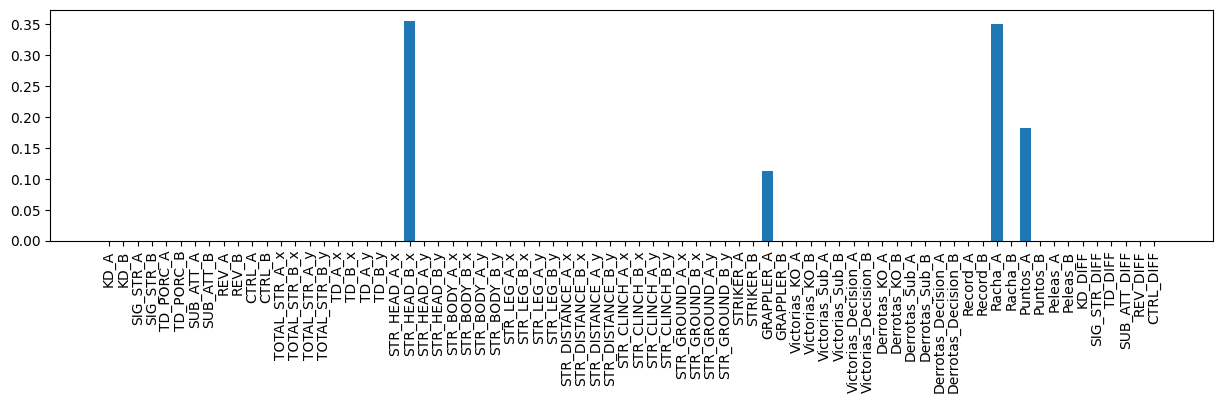

In [45]:
importance = tree2.feature_importances_
feature_names=X_train.columns
for i,v in enumerate(importance):
	if v > 0:
	    print('Variables con importancia en el modelo: %s, Importancia: %.5f' % (feature_names[i],v))

plt.figure(figsize=(15, 3))
plt.bar([x for x in range(len(importance))], importance, tick_label = feature_names)
plt.xticks(rotation = 90)
plt.show()

In [46]:
#Observamos todos los valores de las métricas.
print("-- Métricas del modelo con hiperparámetros ajustados --")
y_val_pred = tree2.predict(X_val)
y_val_prob = tree2.predict_proba(X_val)[:,1]
print("Accuracy:", accuracy_score(y_val, y_val_pred))
f1_val = f1_score(y_val, y_val_pred)
roc_auc_val = roc_auc_score(y_val, y_val_prob)
precision_val = precision_score(y_val, y_val_pred)
recall_val = recall_score(y_val, y_val_pred)
log_loss_val = log_loss(y_val,y_val_prob)

print(f"F1-Score: {f1_val:.4f}")
print(f"AUC-ROC: {roc_auc_val:.4f}")
print(f"Precisión: {precision_val:.4f}")
print(f"Sensibilidad: {recall_val:.4f}")
print(f"Log-loss: {log_loss_val}")
print(confusion_matrix(y_val, y_val_pred))



-- Métricas del modelo con hiperparámetros ajustados --
Accuracy: 0.5157657657657657
F1-Score: 0.5674
AUC-ROC: 0.5480
Precisión: 0.4829
Sensibilidad: 0.6878
Log-loss: 0.6916916378399818
[[ 88 151]
 [ 64 141]]


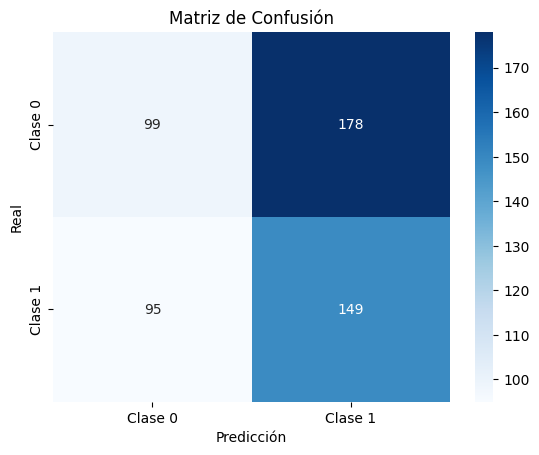

In [75]:
# Calcular la matriz de confusión
cm = confusion_matrix(y_val, y_val_pred)

# Visualizar la matriz de confusión
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Clase 0', 'Clase 1'], yticklabels=['Clase 0', 'Clase 1'])
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión')
plt.show()

El modelo con Random Search es casi idéntico al realizado con Grid Search anteriormente.